# Exploring Sensor Data Distribution

**Table of Contents:**  
- [Configuration](#Configuration)
- [Preparation](#Preparation)
- [Distribution Plots](#Distribution-Plots)
   - [Global](#Global)
   - [Per Subject](#Per-Subject)
   - [Per Session](#Per-Session)
- [Conclusion TBD](#Conclusion)

In [1]:
# Standard
from pathlib import Path
import os
import sys

# Extra
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from tqdm.auto import tqdm

# Custom
module_path = os.path.abspath(os.path.join(".."))  # supposed to be parent folder
if module_path not in sys.path:
    sys.path.append(module_path)
from src.utility.dataset_loader_hdf5 import DatasetLoader

%run utils.ipynb

## Configuration

In [2]:
# Limit data being loaded, useful for dev. For productive, set to "None"
MAX_SUBJECTS = 5  # Number of different users to include in data
SUBJECTS_TEST_VALID = 2  # Not used here
TASK_TYPES = None  # Limit scenarios to [1, 3, 5] for sitting or [2, 4, 6] for walking

# Various Settings
SEED = 712  # Used for every random function

TABLE_NAME = "sensors_100hz"
HMOG_HDF5 = Path.cwd().parent / "data" / "processed" / "hmog_dataset.hdf5"
FEATURE_COLS = [
    "acc_x",
    "acc_y",
    "acc_z",
    "gyr_x",
    "gyr_y",
    "gyr_z",
    "mag_x",
    "mag_y",
    "mag_z",
]
EXCLUDE_SUBJECTS = [
    "733162",  # No 24 sessions
    "526319",  # ^
    "796581",  # ^
    "539502",  # Least amount of sensor values
    "219303",  # ^
    "737973",  # ^
    "986737",  # ^
    "256487",  # Most amount of sensor values
    "389015",  # ^
    "856401",  # ^
]
EXCLUDE_COLS = []

# For plots and CSVs
REPORT_PATH = Path.cwd().parent / "reports" / "figures"
REPORT_PATH.mkdir(parents=True, exist_ok=True)

# Plot colors
cmap = cm.get_cmap("tab10")
cmap_tasks = colors.ListedColormap(
    [
        (0.84, 0.15, 0.16),
        (0.17, 0.63, 0.17, 1.0),
        (0.97, 0.28, 0.28),
        (0.27, 0.73, 0.27, 1.0),
        (1.00, 0.45, 0.45),
        (0.37, 0.83, 0.37, 1.0),
    ],
    name="from_list",
    N=None,
)

%matplotlib inline
utils_set_output_style()

## Preparation

Helper function:

Load Dataset:

In [3]:
hmog = DatasetLoader(
    hdf5_file=HMOG_HDF5,
    table_name=TABLE_NAME,
    max_subjects=MAX_SUBJECTS,
    task_types=TASK_TYPES,
    exclude_subjects=EXCLUDE_SUBJECTS,
    exclude_cols=EXCLUDE_COLS,
    seed=SEED,
)

hmog.data_summary()

DataFrame  Memory (MB)     Rows  Columns  Subjects  Sessions
0       all       726.93  6805730       13         5       120
1     index         0.08     2160        4        90      2160

In [4]:
hmog.all.head()

acc_x     acc_y     acc_z     gyr_x     gyr_y     gyr_z      mag_x      mag_y     mag_z       sys_time subject           session  task_type
0 -0.090381  4.936844  8.788516 -0.114537 -0.067501 -0.018326 -27.638000  15.228000 -1.948000  1396226284400  579284  579284_session_1          4
1 -0.166396  5.002883  8.541718 -0.089830 -0.052213 -0.019017 -27.713443  15.182741 -2.058369  1396226284410  579284  579284_session_1          4
2 -0.242412  5.068923  8.294913 -0.065121 -0.036925 -0.019708 -27.788889  15.137482 -2.168741  1396226284420  579284  579284_session_1          4
3 -0.318429  5.134964  8.048109 -0.040413 -0.021637 -0.020400 -27.864334  15.092222 -2.279112  1396226284430  579284  579284_session_1          4
4 -0.332894  5.217962  8.120932 -0.015706 -0.006350 -0.021091 -27.939778  15.046963 -2.389481  1396226284440  579284  579284_session_1          4

## Distribution Plots

### Global

In [5]:
boxplot_param = dict(
    widths=0.6,
    boxprops=dict(linewidth=0.5),
    medianprops=dict(linewidth=0.5, color=(202/255, 18/255, 125/255)),
    whiskerprops=dict(linewidth=0.5),
    flierprops=dict(
        marker="o",
        markersize=1.5,
        markerfacecolor="none",
        markeredgewidth=0.5,
        alpha=0.5,
        linewidth=0.5,
    ),
)

In [6]:
acc_cols = ["acc_x", "acc_y", "acc_z"][::-1]
gyr_cols = ["gyr_x", "gyr_y", "gyr_z"][::-1]
mag_cols = ["mag_x", "mag_y", "mag_z"][::-1]

feature_cols = [acc_cols, gyr_cols, mag_cols]

tasks = {
    1: "Read + Sit",
    2: "Read + Walk",
    3: "Write + Sit",
    4: "Write + Walk",
    5: "Map + Sit",
    6: "Map + Walk",
}

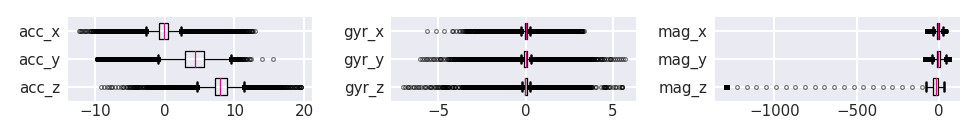

In [7]:
fig, axs = plt.subplots(ncols=3, figsize=(5.473, 0.8), dpi=180)
for idx, cols in enumerate(feature_cols):
    plot = axs[idx].boxplot(
        hmog.all[cols].values, labels=cols, vert=False, **boxplot_param
    )
fig.tight_layout()
plt.show()

### Per Subject

In [8]:
def dist_subject_wise(df, sharex="col", title="SET TITLE", adjust_top=0.90):
    subject_count = len(df["subject"].unique())

    fig, axs = plt.subplots(
        ncols=3,
        nrows=subject_count,
        sharex=sharex,
        figsize=(5.473, 0.8 * subject_count),
        dpi=180,
    )
    for nrow, (subject, df_group) in enumerate(df.groupby("subject")):
        # Plots
        for ncol, features in enumerate(feature_cols):
            axs[nrow, ncol].boxplot(
                df_group[features].values, labels=features, vert=False, **boxplot_param
            )
            axs[nrow, ncol].tick_params(labelbottom=True)  # axis for subplots
        # Title
        axs[nrow, 1].set_title(
            f"Subject {subject}", color=cmap(nrow), fontweight="bold", fontsize=6
        )
    if title and len(title) > 0:
        plt.suptitle(title, fontsize=7)

    fig.tight_layout()

    if title and len(title) > 0:
        plt.subplots_adjust(top=adjust_top)

#### Raw Values

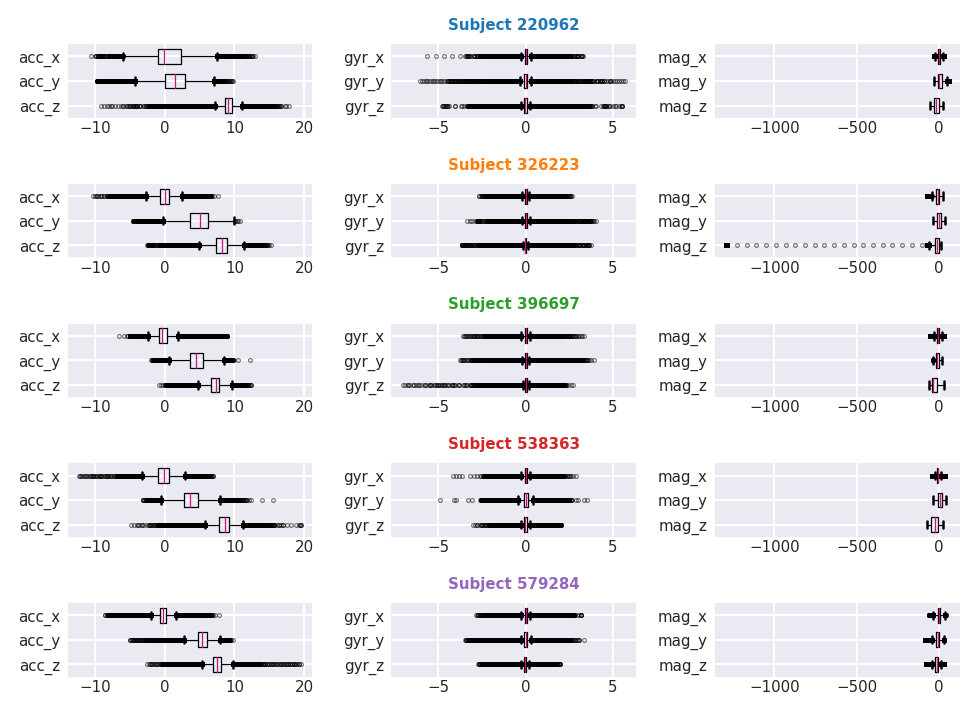

In [9]:
dist_subject_wise(hmog.all, title="");
utils_save_plot(plt, REPORT_PATH / f"buech2019-distributions-raw.png")

#### MinMax Scaled

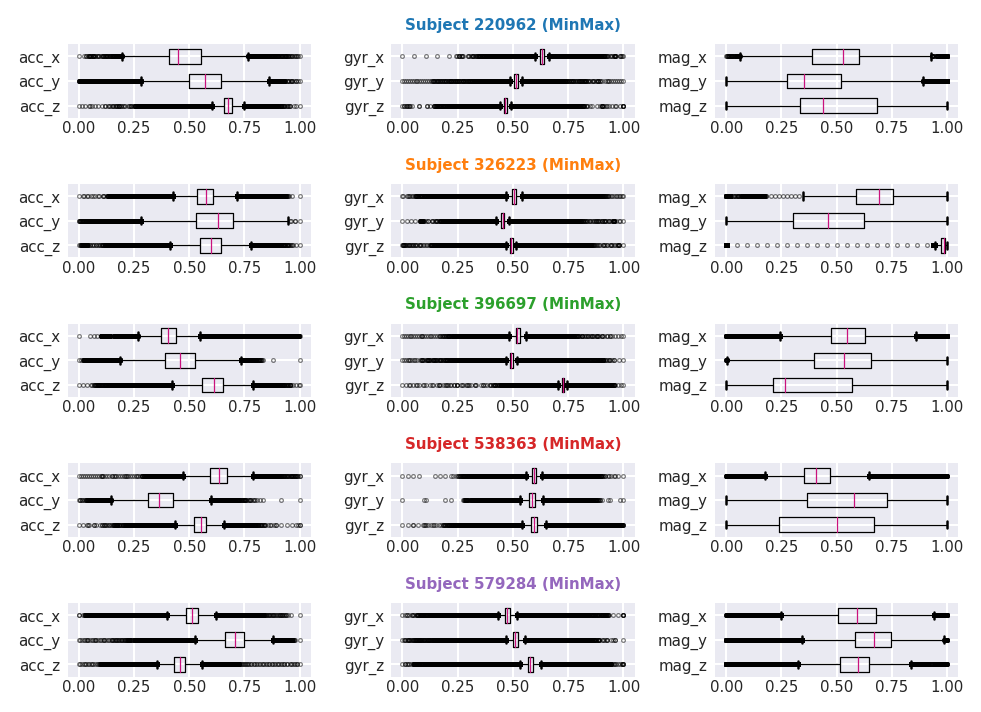

In [10]:
df_scaled_minmax, _ = utils_custom_scale(
        hmog.all,
        scale_cols=FEATURE_COLS,
        feature_cols=FEATURE_COLS,
        scaler_name="minmax",
        scope="subject",
        plot=False,
    )
df_scaled_minmax["subject"] = df_scaled_minmax["subject"] + " (MinMax)"
dist_subject_wise(df_scaled_minmax, title="");
utils_save_plot(plt, REPORT_PATH / f"buech2019-distributions-minmax.png")

#### Standard Scaled

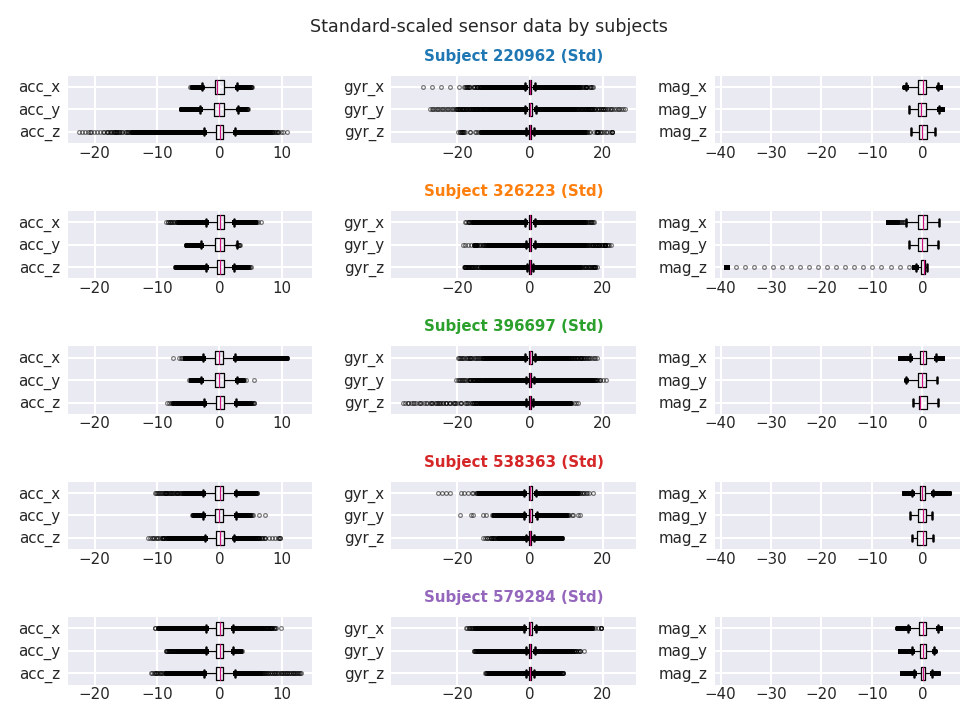

In [11]:
df_scaled_std, _ = utils_custom_scale(
        hmog.all,
        scale_cols=FEATURE_COLS,
        feature_cols=FEATURE_COLS,
        scaler_name="std",
        scope="subject",
        plot=False,
    )
df_scaled_std["subject"] = df_scaled_std["subject"] + " (Std)"
dist_subject_wise(df_scaled_std, title="Standard-scaled sensor data by subjects")

#### Robust Scaled

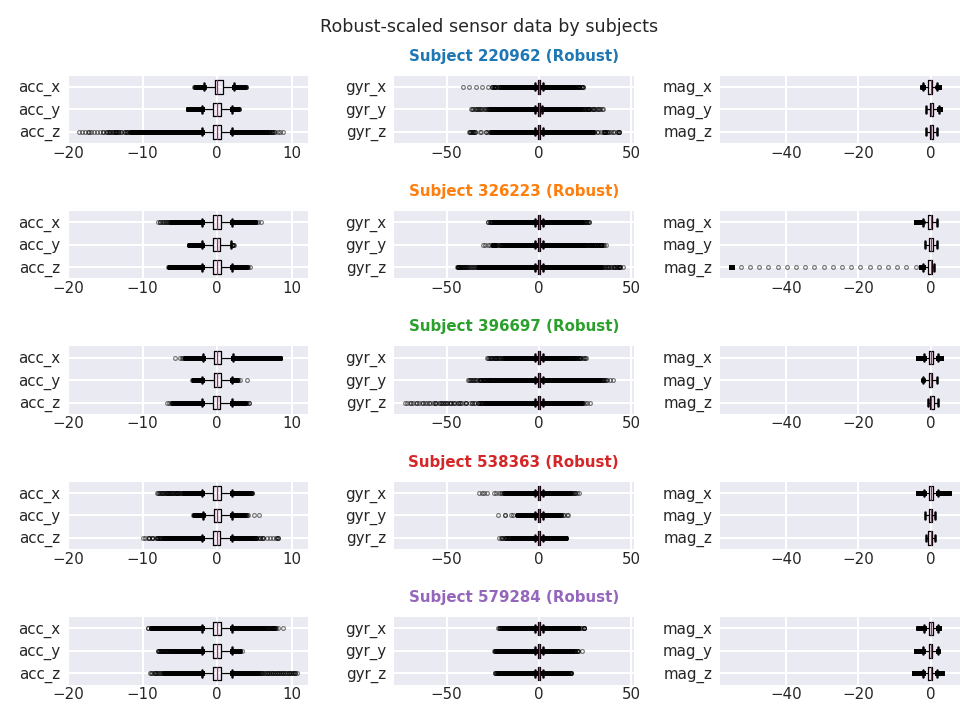

In [12]:
df_scaled_robust, _ = utils_custom_scale(
        hmog.all,
        scale_cols=FEATURE_COLS,
        feature_cols=FEATURE_COLS,
        scaler_name="robust",
        scope="subject",
        plot=False,
    )
df_scaled_robust["subject"] = df_scaled_robust["subject"] + " (Robust)"
dist_subject_wise(df_scaled_robust, title="Robust-scaled sensor data by subjects")

#### MinMax Fixed Scaled

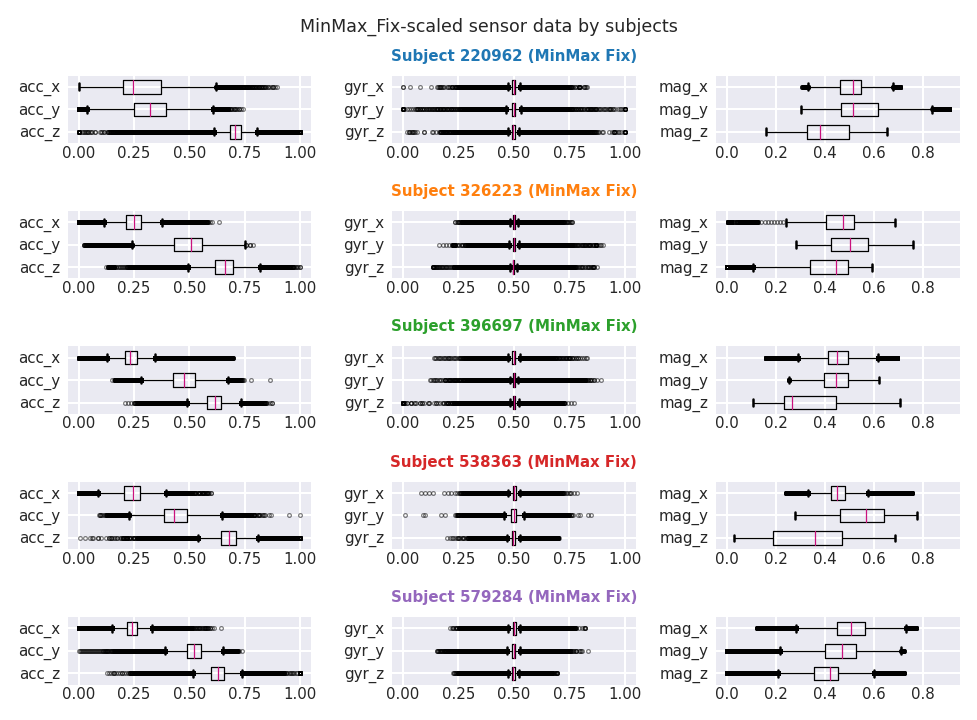

In [13]:
df_scaled_minmax_fix, sc = utils_custom_scale(
        hmog.all,
        scale_cols=FEATURE_COLS,
        feature_cols=FEATURE_COLS,
        scaler_name="minmax_fix",
        scope="subject",
        plot=False,
    )
df_scaled_minmax_fix["subject"] = df_scaled_minmax_fix["subject"] + " (MinMax Fix)"
dist_subject_wise(df_scaled_minmax_fix, title="MinMax_Fix-scaled sensor data by subjects")

#### Robust scaled without centering

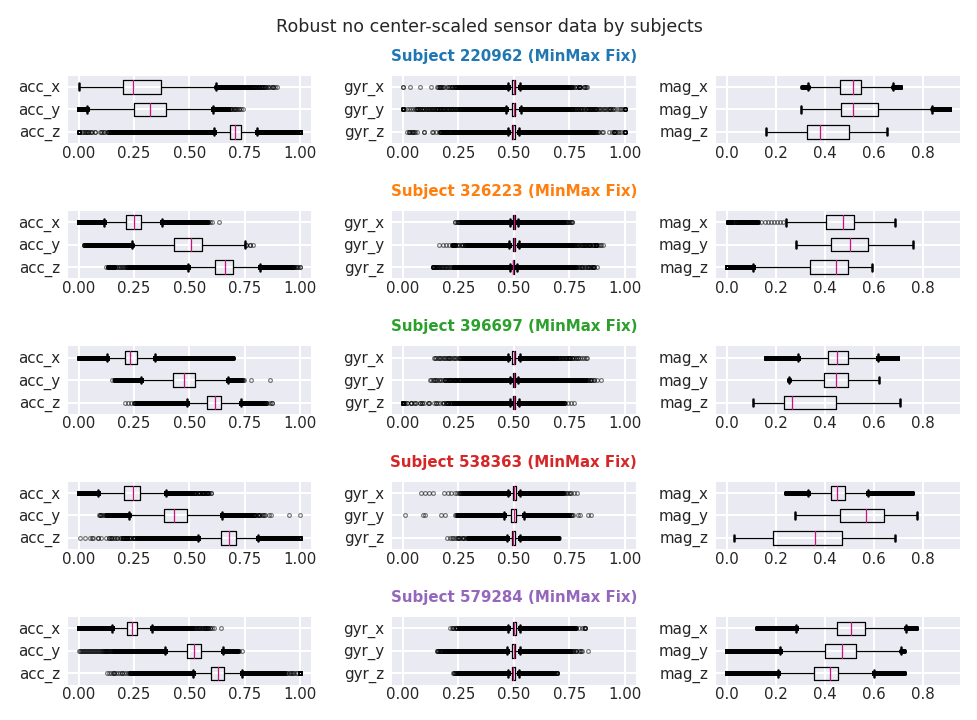

In [14]:
df_scaled_robust_no_center, sc = utils_custom_scale(
        hmog.all,
        scale_cols=FEATURE_COLS,
        feature_cols=FEATURE_COLS,
        scaler_name="robust_no_center",
        scope="subject",
        plot=False,
    )
df_scaled_robust_no_center["subject"] = df_scaled_robust_no_center["subject"] + " (robust nc)"
dist_subject_wise(df_scaled_minmax_fix, title="Robust no center-scaled sensor data by subjects")

#### Direct comparison

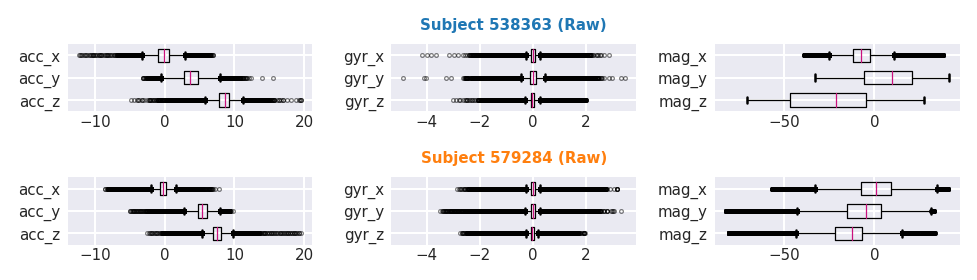

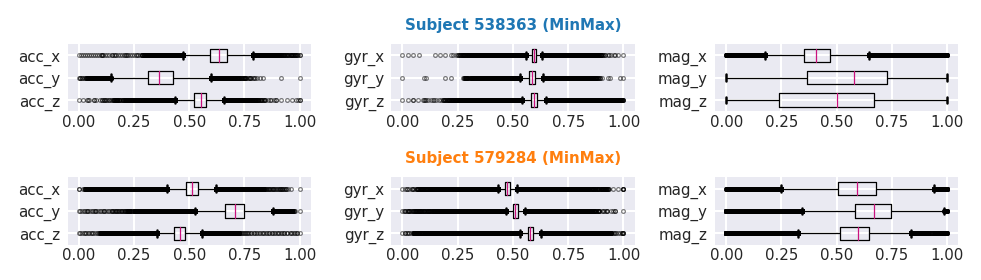

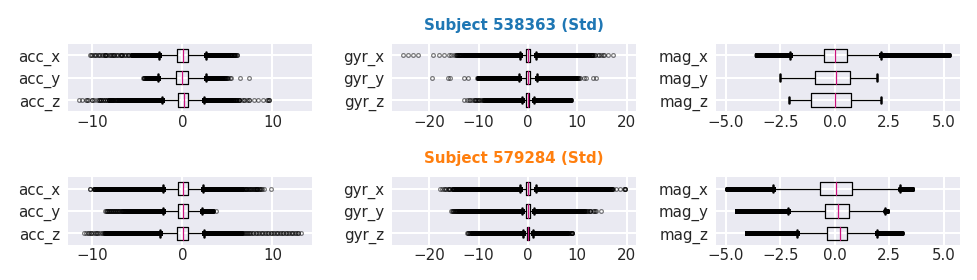

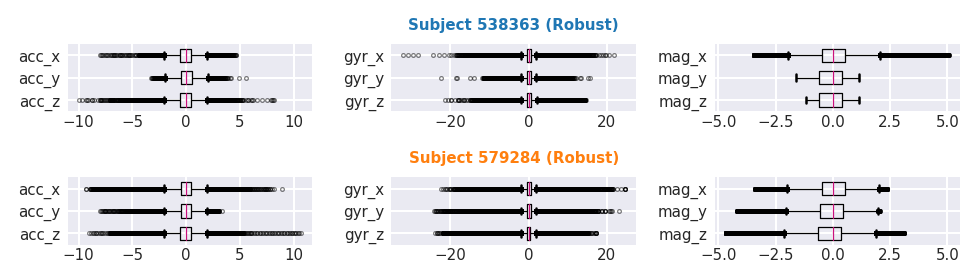

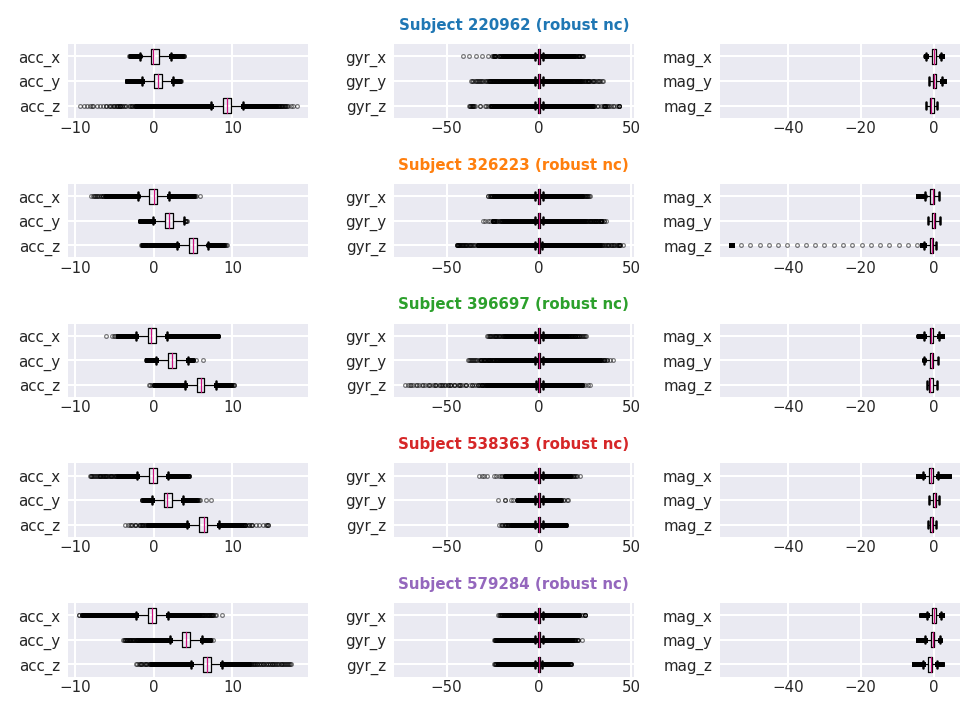

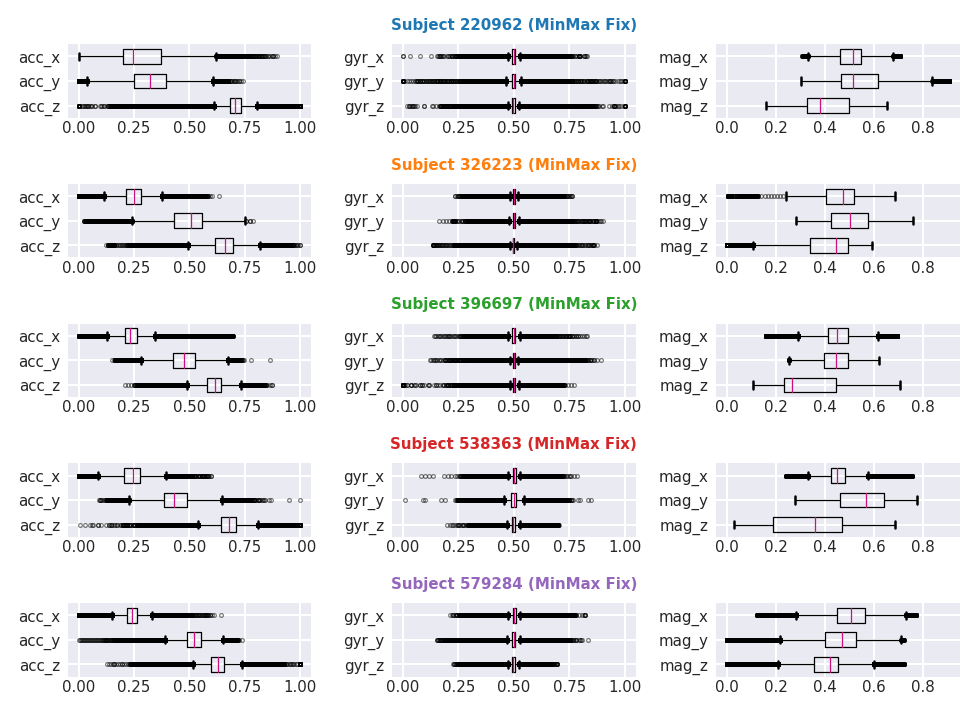

In [15]:
np.random.seed(SEED)
random_subject = np.random.choice(hmog.all["subject"].unique(), size=2, replace=False)

df_raw = hmog.all[hmog.all["subject"].isin(random_subject)].copy()
df_raw["subject"] = df_raw["subject"] + " (Raw)"
df_minmax = df_scaled_minmax[df_scaled_minmax["subject"].isin([s + " (MinMax)" for s in random_subject])]
df_std = df_scaled_std[df_scaled_std["subject"].isin([s + " (Std)" for s in random_subject])]
df_robust = df_scaled_robust[df_scaled_robust["subject"].isin([s + " (Robust)" for s in random_subject])]

dist_subject_wise(df_raw, title="", adjust_top=0.85)
print()
dist_subject_wise(df_minmax, title="", adjust_top=0.85)
print()
dist_subject_wise(df_std, title="", adjust_top=0.85)
print()
dist_subject_wise(df_robust, title="", adjust_top=0.85)
print()
dist_subject_wise(df_scaled_robust_no_center, title="", adjust_top=0.85)
print()
dist_subject_wise(df_scaled_minmax_fix, title="", adjust_top=0.85)

### Per Session

In [16]:
def dist_session_wise(df, sharex="col", title="SET TITLE", adjust_top=0.5):

    # Create Plot Grid
    session_count = len(df["session"].unique())
    fig, axs = plt.subplots(
        ncols=3,
        nrows=session_count,
        sharex=sharex,
        figsize=(5.473, 0.8 * session_count),
        dpi=180,
    )

    # Loop session by session
    prev_subject = None
    subject_counter = -1  # for setting subject color
    for nrow, (session, df_group) in enumerate(df.groupby("session")):
        subject = df_group["subject"].iloc[0]
        if prev_subject != subject:
            prev_subject = subject
            subject_counter += 1

        # Plots
        for ncol, features in enumerate(feature_cols):
            axs[nrow, ncol].boxplot(
                df_group[features].values, labels=features, vert=False, **boxplot_param
            )
            axs[nrow, ncol].tick_params(labelbottom=True)  # axis for subplots

        # Labels
        task_id = int(df_group["task_type"].max())
        task_type = tasks[task_id]
        axs[nrow, 0].set_title(
            f"Subject {subject}",
            color=cmap(subject_counter),
            loc="right",
            fontweight="bold",
            x=1.3,
            fontsize=6,
        )
        axs[nrow, 1].set_title(
            f"Session {session.split('_')[-1]}", fontweight="bold", fontsize=6
        )
        axs[nrow, 2].set_title(
            f"{task_type}",
            color=cmap_tasks(task_id),
            loc="right",
            fontweight="bold",
            x=0.04,
            fontsize=6,
        )

    plt.suptitle(title, fontsize=7)
    plt.subplots_adjust(
        top=adjust_top, wspace=0.3, hspace=1.1 - adjust_top/session_count
    )
    plt.show()
    

#### Raw values

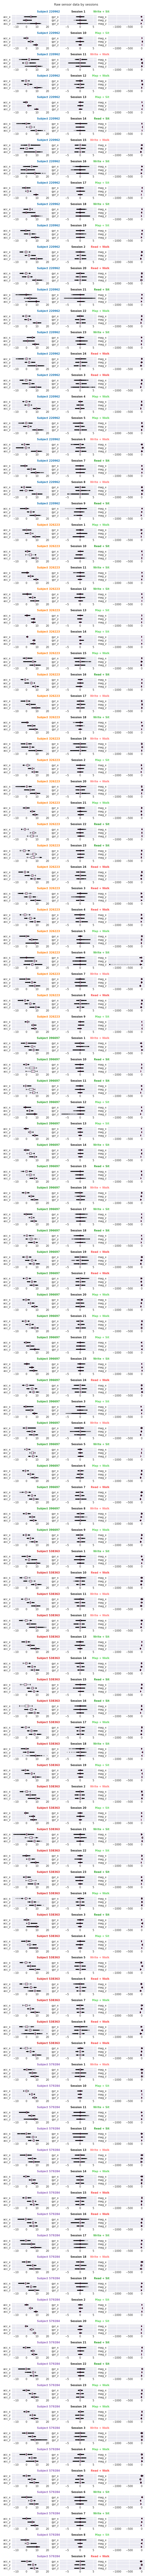

In [17]:
dist_session_wise(hmog.all, title="Raw sensor data by sessions", adjust_top=0.976)

#### MinMax Scaled

In [ ]:
df_scaled, _ = utils_custom_scale(
        hmog.all,
        scale_cols=FEATURE_COLS,
        feature_cols=FEATURE_COLS,
        scaler_name="minmax",
        scope="session",
        plot=False,
    )
df_scaled["session"] = df_scaled["session"] + " (MinMax)"
dist_session_wise(df_scaled, title="MinMax-scaled sensor data by sessions", adjust_top=0.976)

#### Direct comparison

In [ ]:
np.random.seed(SEED)

random_subjects = np.random.choice(hmog.all["subject"].unique(), size=3, replace=False)
random_sessions = (
    hmog.all[hmog.all["subject"].isin(random_subjects)]
    .groupby("subject")
    .apply(lambda x: x.sample(n=2, random_state=SEED))["session"]
    .unique()
)

df_raw = hmog.all[hmog.all["session"].isin(random_sessions)]
df_minmax = df_scaled[
    df_scaled["session"].isin([s + " (MinMax)" for s in random_sessions])
]

dist_session_wise(df_raw, title="Raw sensor data by sessions", adjust_top=0.90)
print("\n")
dist_session_wise(
    df_minmax, title="MinMax-scaled sensor data by sessions", adjust_top=0.90
)